<a href="https://colab.research.google.com/github/jzyee/water_stress_proj/blob/master/covariate_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# installs

In [1]:
! pip install --upgrade statsmodels
! pip install tslearn
! pip install pycausalimpact
! pip install ruptures

     |████████████████████████████████| 17.5MB 235kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for statsmodels: filename=statsmodels-0.12.0-cp36-cp36m-linux_x86_64.whl size=17697030 sha256=a410dd7ae7b350b30bebb8fa315d6af57eff9013f5e83fc42d9ded99ce76d19f
  Stored in directory: /root/.cache/pip/wheels/13/e2/97/457e5f326324f1ced0e355792c11285d6b15f41376871935a9
Successfully built statsmodels
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 778kB 2.7MB/s 
     |████████████████████████████████| 61kB 1.8MB/s 


# mount

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
% cd /content/gdrive/'My Drive'/water_stress_detection

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/water_stress_detection


# imports

In [9]:
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.layers import Bidirectional
import tensorflow as tf
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
from sklearn import preprocessing
import time

plt.rcParams["figure.figsize"] = (18,6)


In [4]:
harm_df = pd.read_csv('data_files/processed_harm_ndvi.csv', parse_dates=True)
harm_df.index = pd.to_datetime(harm_df.iloc[:,0], format='%Y-%m-%d') 
harm_df = harm_df.iloc[:,1:]
harm_df.index.name = 'Date'

#full years only
harm_df = harm_df.loc[(harm_df.index > '1986') & (harm_df.index < '2019')]

harm_df.head()

,FMMOL,E12,ELFI,BBOB,VERMTL,CAN,befa,TZEI,GERM210,FELSM,CRO,UK67,OGEW,FSGW,FOU,SWIT259,VERM11,UK99,OSDS,Kom,SERR15,WESC,TOC,BOS_PER,OeS,OR2,Sinca3,OSSA06,CRO_CUD,MBA,E17,UK62,SZBH,CLFS,Sinca6,KNJB,E07,DRFS,QPOM,Gks,...,SHTS,CRO_RAM,RIED,DOFS,MSC,LR3,M04,MWSB,E09,PENNA,CEB,E39,UK10,FPTRE2,FSSW,QGHC,GERM206,DK1014,ROM_SEB,KAMP,M27,mos,SLO_SUT,HSKM,MON1,PIOV,NGMW,PWTS,FS30,s121,BALD,Runcu2,Z1,ITAL037,AGNE,LE50,NGLS,AFO,M11,BB
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1986-01-31,0.588699,0.532026,-0.117098,0.261137,-0.106084,0.195253,0.385088,-0.053554,0.539252,0.175342,0.281760,0.129390,-0.023868,0.565244,0.536370,-0.015052,0.401894,0.328261,0.102050,0.623523,0.401523,0.662059,0.496613,0.595116,0.682529,-0.012000,0.346003,0.241364,0.792553,0.304651,0.256432,0.667815,0.461104,0.252426,0.482364,0.675806,0.400853,0.497374,0.150064,0.505505,...,0.624156,0.759213,0.509677,0.790643,0.449974,0.572477,0.414582,0.638375,0.487695,0.759517,0.544454,0.249647,0.279786,0.405226,0.318868,0.403744,0.683440,0.711980,0.780428,0.472334,0.625440,0.663763,0.255201,0.588158,0.364799,0.617671,0.089124,0.106188,0.683394,0.392504,0.601957,0.442854,0.536782,0.277185,0.770591,0.436001,0.000922,0.476973,0.702265,0.399661
1986-02-28,0.554890,0.457753,0.007323,0.321345,0.015089,0.258110,0.379697,-0.063945,0.483418,0.223198,0.313686,0.113259,0.069031,0.562188,0.565291,0.151749,0.388719,0.138581,0.007619,0.600863,0.382496,0.659720,0.404516,0.583059,0.676510,-0.036839,0.336819,0.337653,0.796227,0.316285,0.173154,0.689458,0.394655,0.217054,0.472183,0.643122,0.399247,0.431509,0.012488,0.481699,...,0.627678,0.758698,0.522640,0.794796,0.408326,0.624847,0.424374,0.612923,0.432580,0.776336,0.503469,0.239058,0.296808,0.440045,0.379310,0.363100,0.672214,0.713632,0.781307,0.441170,0.664792,0.674327,0.006935,0.558765,0.316708,0.610609,-0.045802,0.102431,0.717420,0.309421,0.612397,0.456885,0.505272,0.305149,0.774930,0.503290,-0.123177,0.192814,0.728536,0.336341
1986-03-31,0.521082,0.383480,0.137212,0.381553,0.136262,0.320967,0.374306,0.190980,0.369832,0.271054,0.345612,0.097127,0.189324,0.559132,0.594211,0.318550,0.375544,0.276540,0.179150,0.578203,0.363469,0.657381,0.312419,0.571002,0.670491,-0.061677,0.327635,0.433942,0.799901,0.327920,0.384636,0.711101,0.328205,0.181681,0.462002,0.610438,0.397641,0.365643,0.161717,0.457892,...,0.631201,0.758183,0.535603,0.798949,0.366679,0.677217,0.434167,0.587471,0.377465,0.793155,0.462483,0.228470,0.373729,0.474864,0.491146,0.322456,0.660987,0.715284,0.782187,0.410006,0.704144,0.684891,0.172465,0.529373,0.446663,0.603547,0.108988,0.098675,0.751445,0.226337,0.622837,0.470915,0.473762,0.333112,0.779268,0.570578,-0.093596,0.296651,0.754806,0.273021
1986-04-30,0.611562,0.457194,0.347790,0.441762,0.257435,0.383823,0.618736,0.351527,0.256246,0.318911,0.377537,0.080996,0.309618,0.556076,0.623131,0.485351,0.362369,0.414498,0.350682,0.467087,0.344442,0.655042,0.427420,0.655196,0.664472,0.028713,0.318450,0.530231,0.803574,0.339554,0.596118,0.732744,0.460783,0.146309,0.451820,0.577754,0.396035,0.299778,0.310945,0.434086,...,0.634724,0.757668,0.548566,0.803102,0.508223,0.729587,0.443959,0.562019,0.465331,0.809975,0.421498,0.440522,0.450651,0.509684,0.602981,0.502128,0.649760,0.716936,0.783066,0.378842,0.743496,0.695455,0.337995,0.499981,0.576618,0.596485,0.263777,0.115137,0.785471,0.357857,0.633277,0.484946,0.442252,0.505279,0.783607,0.637867,0.073822,0.400489,0.781077,0.375902
1986-05-31,0.754400,0.530909,0.558369,0.501970,0.378609,0.446680,0.863166,0.512075,0.728913,0.366767,0.704559,0.064864,0.429911,0.553019,0.670218,0.652151,0.762470,0.552457,0.522213,0.711666,0.569144,0.652703,0.542421,0.739389,0.658453,0.119103,0.694756,0.769430,0.807248,0.515376,0.807600,0.754387,0.593361,0.769488,0.763666,0.545070,0.394429,0.779172,0.460174,0.758588,...,0.638246,0.757153,0.561529,0.807256,0.649768,0.781957,0.453752,0.536567,0.553197,0.826794,0.633318,0.652574,0.527572,0.418655,0.714817,0.624442,0.638534,0.71858

In [7]:
[col for col in harm_df if harm_df[col].std() == harm_df.std().min()]

['E50']

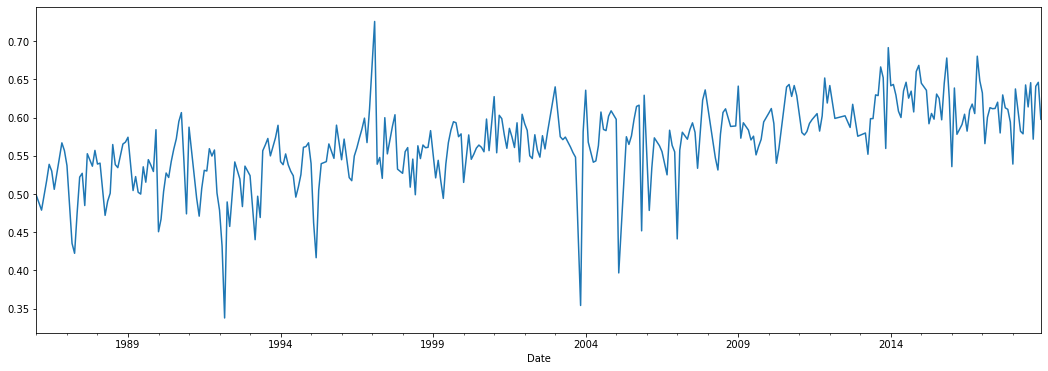

In [10]:
harm_df['E50'].plot()

,wave
date,
1986-01-31,-0.169239
1986-02-28,-0.161670
1986-03-31,-0.110790
1986-04-30,-0.030229
1986-05-31,0.058431


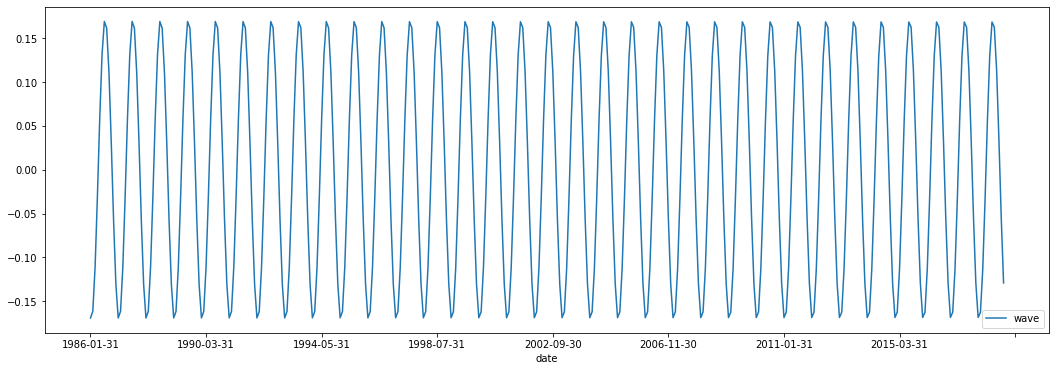

In [13]:
season_comp = pd.read_csv('synthetic_component/wave.csv', index_col='date')
#full years only
season_comp = season_comp.loc[(season_comp.index > '1986') & (season_comp.index < '2019')]
display(season_comp.head())
season_comp.plot()

In [24]:
comb_df = season_comp.copy()
for idx, site in enumerate(harm_df.columns):
  comb_df[site] = harm_df[site]

comb_df = comb_df.rename(columns={'wave': 'periodic_waveform'})
comb_df.corr().iloc[:10,:10]

,periodic_waveform,FMMOL,E12,ELFI,BBOB,VERMTL,CAN,befa,TZEI,GERM210
periodic_waveform,1.000000,0.666101,0.532382,0.832763,0.741464,0.800090,0.785764,0.799301,0.825078,0.497285
FMMOL,0.666101,1.000000,0.431803,0.711894,0.501697,0.589826,0.734544,0.577065,0.642299,0.397567
E12,0.532382,0.431803,1.000000,0.507041,0.510725,0.395783,0.418549,0.419317,0.426747,0.367561
ELFI,0.832763,0.711894,0.507041,1.000000,0.647088,0.691528,0.806403,0.716396,0.772432,0.418719
BBOB,0.741464,0.501697,0.510725,0.647088,1.000000,0.638364,0.656180,0.564565,0.585080,0.485521
VERMTL,0.800090,0.589826,0.395783,0.691528,0.638364,1.000000,0.739455,0.689594,0.752551,0.420646
CAN,0.785764,0.734544,0.418549,0.806403,0.656180,0.739455,1.000000,0.690216,0.718871,0.422962
befa,0.799301,0.577065,0.419317,0.716396,0.564565,0.689594,0.690216,1.000000,0.729645,0.481458
TZEI,0.825078,0.642299,0.426747,0.772432,0.585080,0.752551,0.718871,0.729645,1.000000,0.406235
GERM210,0.497285,0.397567,0.367561,0.418719,0.485521,0.420646,0.422962,0.481458,0.406235,1.000000


In [31]:
high_corr_sites = list(comb_df.corr()[comb_df.corr()['periodic_waveform'] > 0.8]['periodic_waveform'].index)
high_corr_sites

['periodic_waveform',
 'ELFI',
 'VERMTL',
 'TZEI',
 'SWIT259',
 'VERM11',
 'Sinca3',
 'CRO_CUD',
 'MBA',
 'Sinca6',
 'E07',
 'DRFS',
 'Gks',
 'M16',
 'rezi',
 'E30',
 'CRO_COR',
 'ROM_BEL',
 'FMPIC',
 'E15',
 'F1',
 'DOB',
 'CDRA',
 'ALB_LUM',
 'VERMSC',
 'BELLEB',
 'NIV3',
 'FS54a',
 'DomEmsU',
 'SNFS',
 'E13',
 'PILI10',
 'M02',
 'FSAR',
 'BERLEB',
 'BNFS',
 'S',
 'rajc',
 'MART',
 'FS81',
 'BAD',
 'VERM08',
 's033',
 'Bvid',
 'ZG',
 'Btdh',
 'ANFS',
 'Bnik',
 'M17',
 'TOB',
 'FS04',
 'Sinca4',
 'VERM13',
 'Bdra',
 'MTCIM',
 'Bgar',
 'maly',
 'E06',
 'kayh',
 'VERM14',
 'PAGG09',
 'ROM_IZV',
 's099',
 'Bcas',
 'E37',
 'RIFS',
 'E41',
 'FS29',
 'LAEB',
 'M06',
 'NGMK',
 'Kff',
 's094',
 'Btjn',
 'BUL_BOA',
 'TWFS',
 'Runcu4',
 'FS54b',
 'BA',
 'Sinca5',
 'TSSW',
 'FS65',
 'ASFS',
 'UMBR',
 'nuert',
 'FS02',
 'CRO_RIE',
 'FSPL',
 'JAV',
 'VERM15',
 'E10',
 'M28',
 'Sinca1',
 'LR38',
 'FUNS',
 's097',
 'E38',
 'MELL',
 'FS60',
 'FSSB',
 'STFS',
 'TL',
 'PTFS',
 'LIB1',
 'ME',
 'Sinca2',

In [34]:
name_df = pd.DataFrame({'site_IDs': high_corr_sites[1:]})
name_df.head()

,site_IDs
0,ELFI
1,VERMTL
2,TZEI
3,SWIT259
4,VERM11


In [36]:
name_df.to_csv('data_files/high_corr_site_names.csv')